# Bayesian Inference with an Incremental RSA Model of Adjective Ordering Preferences for Categorical Data in NumPyro
LMBayes Meeting 2025-07-10

### Import relevant packages

In [1]:
# Import packages
import argparse
from typing import Tuple, Dict, List, Any, Sequence, Callable
import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap
import jax
from jax import lax
from jax import random
from jax.random import PRNGKey, split
from functools import partial
import matplotlib.pyplot as plt
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
import numpyro.distributions.constraints as constraints
from numpyro import param, sample
from numpyro.distributions import constraints, HalfNormal, Normal, Uniform

from numpyro import handlers
from numpyro.infer import MCMC, NUTS, HMC, MixedHMC
from numpyro.infer import Predictive
from sklearn.model_selection import train_test_split
numpyro.set_platform("cpu")
numpyro.set_host_device_count(4)
print(jax.__version__)
print(jax.devices())

/Users/heningwang/Documents/GitHub/numpyro_adjective_modelling/jax-metal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!


0.4.20
Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.92 GB

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


2025-11-14 11:35:14.619425: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


## Dataset

**Design:**

F1: In-context informativeness modulated by **relevant property** with three levels *(size relevant, color relevant, both relevant)*

F2: Inherent informativeness of size adjectives modulated by **sharpness** with two levels: *(sharp, blurred)*

<p align="center">
<b>Figure 1</b>: Illustration of the design of experiment items.
</p>

![Experiment Item](experiment_item_illustration.png)

**Independent variables:** The original pictures used in human experiments are encoded into symbolic representations, forming the design matrix for the models. Each object varies along three features: size $s$, color $c$, and form $f$, represented as a one-dimensional tuple $(s, c, f)$. Size is an integer between 1 and 10, while color and form are binary: 1 if the feature matches the referent, 0 otherwise. A context consists of six objects, forming a matrix of shape $(n_{\text{obj}}, n_{\text{features}})$, i.e., $(6,3)$.

**Dependent variables:** free production responses manually annotated into 15 categories, i.e., $(15,)$. These are derived from three basic categories: D, C, and F. By combining different lengths and orderings of these elements, a total of 15 categories are defined. See below for a plot of the empirical distribution across these categories.

**Summary of results and effects we aim to model:** 

1. **Effect of relevant property:** In-context informativeness drives ordering preferences: size-first is preferred in size-relevant contexts, and color-first in color-relevant contexts.

2. **Effect of sharpness:** Size adjectives are used more overinformatively in the blurred condition compared to the sharp condition.


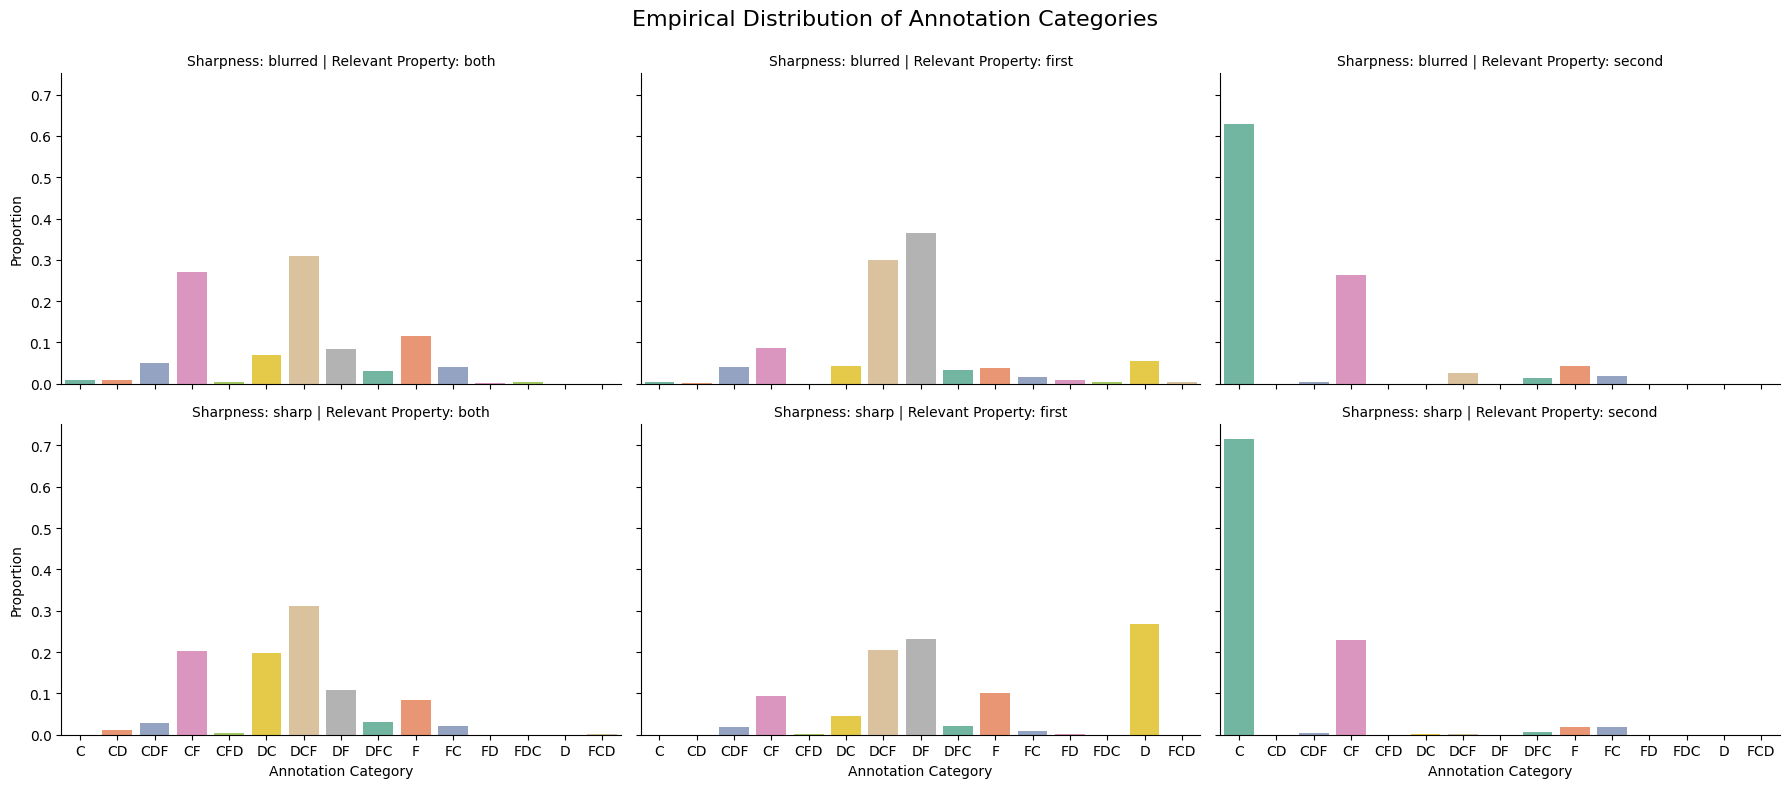

In [2]:
import seaborn as sns

def plot_empirical_distribution(
        file_path: str = "../../01-dataset/01-production-data-preprocessed.csv"
) -> None:
    """
    Plot the empirical distribution of the dependent variable categories.

    Args:
        file_path (str): Path to the CSV file containing the data.
    """
    # Load the data
    df = pd.read_csv(file_path)

    # Drop NAs
    df = df.dropna(subset=["annotation"])
    
    # Subset the data by relevant conditions
    df = df[df["conditions"].isin(["erdc", "zrdc", "brdc"])]

    # Group and normalize
    df_plot = df.groupby(['sharpness', 'relevant_property', 'annotation']).size().reset_index(name='count')
    df_plot['proportion'] = df_plot['count'] / df_plot.groupby(['sharpness', 'relevant_property'])['count'].transform('sum')

    # Set up the plot
    g = sns.catplot(
        data=df_plot,
        kind="bar",
        x="annotation",
        y="proportion",
        col="relevant_property",
        row="sharpness",
        height=4,
        aspect=1.5,
        sharey=True,
        hue="annotation",
        palette="Set2",
    )

    g.set_axis_labels("Annotation Category", "Proportion")
    g.set_titles(row_template="Sharpness: {row_name}", col_template="Relevant Property: {col_name}")
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle("Empirical Distribution of Annotation Categories", fontsize=16)

    plt.show()


plot_empirical_distribution()

**Challenges:**

1. **Computational inefficiency with enumeration**  
   The state space has shape $(6, 3)$ and the utterance space contains 15 categories.  
   Computing the marginal distribution over all states for each utterance (e.g., in a literal listener model) quickly becomes inefficient with enumeration-based inference due to the combinatorial explosion.

2. **Numerical instability with categorical likelihoods**  
   When using a categorical likelihood to model discrete responses:

   - The response variable is a hard label $y_i \in \{1, \dots, K\}$
   - The model outputs predicted probabilities $\boldsymbol{\theta}$ over those $K$ categories
   - The log-likelihood for each observation is:

   $$
   \log p(y_i \mid \boldsymbol{\theta}) = \log \theta_{y_i}
   $$

   Two main issues can arise:

   - **a. Observed categories with near-zero model probability**  
     If $\theta_{y_i} = 0$ and $y_i$ is observed, the log-likelihood becomes $-\infty$, causing NUTS to reject parameter samples due to non-finite posterior density.

   - **b. Data sparsity across conditions**  
     In certain experimental conditions, some categories may be completely unobserved, though not impossible.  
     Without smoothing or a prior, the model may assign zero probability to these categories, resulting in poor generalization and inference instability.

3. **Incompatibility of NUTS with latent discrete variables**  
   NUTS relies on Hamiltonian dynamics, which require gradient information.  
   Since discrete latent variables are not differentiable, NUTS cannot directly handle them.  
   If such variables are part of the model, they must be either marginalized out or replaced with continuous relaxations (e.g., Gumbel-softmax).

## Numpyro Implementation

### Module 1: Encode Design and Data into high-dimensional matrices

**Vectorized computation:**  
NumPyro is a state-of-the-art probabilistic programming framework in Python, built on top of JAX. Its key advantages include support for vectorized computation and automatic differentiation. To fully leverage these capabilities, we structure the design and data as high-dimensional arrays: the design matrix is encoded as a tensor of shape $(n_{\text{data}}, n_{\text{obj}}, n_{\text{features}})$, and the response data as a vector of shape $(n_{\text{data}})$.

**Encoding String to Numeric: Switching Between Hard Labels and Soft Distributions**

Exploratorily, we implement two encoding approaches to support different modeling needs:

- For **data and categorical model outputs**, we use a *flat encoding* with hard labels.  
  Each sequence of category labels (e.g., "D", "DC", "FDC") is assigned a unique integer ID.  
  This representation enables the use of a categorical likelihood over integer-valued labels in a straightforward manner.

- Alternatively, we construct **soft empirical distributions** by aggregating the data across experimental items and normalizing the category counts.  
  This yields probability distributions over categories rather than single labels, allowing us to address data sparsity and likelihood instability (as discussed in Challenge 2).  
  These soft targets are especially useful for training and evaluating models under uncertainty or when aiming for more stable gradient-based inference.

In [3]:
# ========================
# Global Variables (placeholders)
# ========================
utterance_list = None
utterance_prior = None
flat2categories = { "0": "D", 
                            "1": "DC", 
                            "2": "DCF",
                            "3": "DF",
                            "4": "DFC", 
                            "5": "C", 
                            "6": "CD", 
                            "7": "CDF",
                            "8": "CF",
                            "9": "CFD",
                            "10": "F",
                            "11": "FD",
                            "12": "FDC",
                            "13": "FC",
                            "14": "FCD"}
# ========================
def import_dataset(
    file_path: str = "../../01-dataset/01-production-data-preprocessed.csv",
    flag_output_empirical_dist_by_conditions: bool = False
    ):
    """
    Load the dataset and preprocess it.
    - Load the data from a CSV file
    - Drop missing values in the 'annotation' column
    - Subset the data by conditions to include only conditions involving relevant manipulation to size adjectives
    - Encode states via vectorized slicing
    - Encode utterances using different methods:
        1) build a sequence of symbols for each utterance
        2) build a flat codes for the utterances given the sequence string
    - Add all encodings to the DataFrame
    - Return a dictionary with all the relevant data
    Args:
        file_path: path to the CSV file
    Returns:    
        A dictionary with the following keys:
            - states_train: jnp.ndarray of shape (N, 6, 3)
            - empirical_flat: jnp.ndarray of shape (N,)
            - empirical_seq: jnp.ndarray of shape (N, max_len)
            - seq_mask: jnp.ndarray of shape (N, max_len)
            - df: DataFrame with all the relevant data
            - unique_utterances: jnp.ndarray of shape (U, max_len)
            - empirical_seq_flat: jnp.ndarray of shape (N,)
    """
    # Load & drop missing
    df = pd.read_csv(file_path)
    df = df.dropna(subset=["annotation"]).copy()

    # Subset the data by conditions to include only conditions involving relevant manipulation to size adjectives
    df = df[df["conditions"].isin(["erdc", "zrdc", "brdc"])]

    # Encode states via vectorized slicing
    #    – sizes are numeric already
    #    – colors: "blue"→1, else 0
    #    – forms:  "circle"→1, else 0
    sizes = df.iloc[:, 6:12].to_numpy(dtype=float)                  # (N,6)
    colors = (df.iloc[:, 12:18] == "blue").to_numpy(dtype=int)      # (N,6)
    forms  = (df.iloc[:, 18:24] == "circle").to_numpy(dtype=int)    # (N,6)

    # Stack into shape (N,6,3)
    states_np = np.stack([sizes, colors, forms], axis=2) 
    states_train = jnp.array(states_np)                # (N,6,3)

    # Encode uttrances using different methods
    # 1) Build a sequence of symbols for each utterance
    # D = 0, C = 1, F = 2, padding = -1
    # e.g. DCF is [0,1,2] and D is [0, -1, -1]
    symbol2idx = {"D": 0, "C": 1, "F": 2}
    max_len = 3

    # Pull out the raw strings in plain Python
    utt_strings = df["annotation"].tolist()   # e.g. ["D","CF","FDC",...]

    # Turn each string into a list of symbol‐ints
    sequences = []
    for u in utt_strings:
        seq = [symbol2idx[ch] for ch in u]
        # pad with -1 up to max_len
        seq = seq + [-1] * (max_len - len(seq))
        sequences.append(seq)

    # Stack into one jnp.ndarray
    empirical_seq = jnp.array(sequences, dtype=jnp.int32)  # shape (N, max_len)


    # 2) Build a flat codes for the utterances given the sequence string
    # Get the unique utterances string from empirical_seq
    unique_utterances = jnp.unique(empirical_seq, axis=0)  # shape (U, max_len)

    # Build a dict mapping each unique utterance to its index
    uttSeq2idx = {tuple(u): i for i, u in enumerate(unique_utterances.tolist())}
    # Map each utterance in the sequence to its index
    empirical_seq_flat = jnp.array(
        [uttSeq2idx[tuple(u)] for u in empirical_seq.tolist()],
        dtype=jnp.int32
    )  # shape (N,)
    # Add all encodings to the DataFrame
    df["statesArray"] = states_train.tolist()  # shape (N,)
    df["annotation_seq"] = empirical_seq.tolist()  # shape (N,)
    df["annotation_seq_flat"] = empirical_seq_flat.tolist()  # shape (N,)

    if not flag_output_empirical_dist_by_conditions:
    # Return a dictionary with all the relevant data
        return {
            "states_train": states_train,
            "empirical_seq": empirical_seq,
            "df": df,
            "unique_utterances": unique_utterances,
            "empirical_seq_flat": empirical_seq_flat,
        }
    else:
        # Group by item and list, and calculate the empirical distribution of annotations
        empirical_dist_by_condition = df.groupby(["item", "list"])["annotation_seq_flat"].value_counts(normalize=True).unstack(fill_value=0)
        empirical_dist_by_condition = jnp.array(empirical_dist_by_condition.values, dtype=jnp.float32)

        # Convert the statesArray to a jnp.ndarray of shape (n_conditions, 6, 3)
        grouped_states = df.groupby(["item", "list"])["statesArray"].first().reset_index(drop=True)
        states_array_by_condition = jnp.array(np.stack(grouped_states.values), dtype=jnp.float32)

        # Modify to return new grouped dataframe
        df_grouped = df[["relevant_property", "sharpness", "item", "list", "statesArray"]].copy()
        df_grouped = df_grouped.sort_values(["item", "list"])
        # Reduce df_grouped to unique rows
        df_grouped = (
            df_grouped.groupby(["item", "list"], sort=False)
            .apply(lambda x: x.iloc[0])
            .reset_index(drop=True)
        )

        # Add the statesArray to df_grouped
        df_grouped["statesArray"] = states_array_by_condition.tolist()  # shape (n_conditions, 6, 3)
        df_grouped["empirical_dist"] = empirical_dist_by_condition.tolist()  # shape (n_conditions, n_utterances)
        # Convert empirical_dist_by_condition to a DataFrame
        # with columns named according to flat2categories
        empirical_dist_df = pd.DataFrame(empirical_dist_by_condition, columns=[flat2categories[str(i)] for i in range(empirical_dist_by_condition.shape[1])])
        df_full = pd.concat([df_grouped.reset_index(drop=True), empirical_dist_df], axis=1)
       
        # 3. Convert to long format: melt category columns into two columns: 'annotation', 'probability'
        df_long = df_full.melt(
            id_vars=["relevant_property", "sharpness","item", "list", "statesArray"],
            value_vars=list(flat2categories.values()),
            var_name="empirical_annotation_category",
            value_name="probability"
        )
        return {
            "states_array_by_condition": states_array_by_condition,  # shape (n_conditions, 6, 3)
            "empirical_dist_by_condition": empirical_dist_by_condition,  # shape (n_conditions, n_utterances)
            "df": df_grouped,
            "df_long": df_long,  # long format DataFrame
        }

In [4]:
# Empirical hard labels
data = import_dataset()
states_train = data["states_train"]
empirical_train = data["empirical_seq_flat"]
df = data["df"]


print("States train shape:", states_train.shape)
print("Empirical train shape:", empirical_train.shape)
# ========================
print("States train:", states_train[0:3])
print("Empirical train:", empirical_train[0:3])

print(df["annotation"][0:3])

example_index = 5
example_state = states_train[example_index]
example_annotation_flat = empirical_train[example_index]
example_annotation = df["annotation"].iloc[example_index]
print("Example state:", example_state)

States train shape: (3196, 6, 3)
Empirical train shape: (3196,)
States train: [[[ 9.  1.  1.]
  [10.  0.  0.]
  [10.  0.  1.]
  [10.  0.  1.]
  [10.  0.  1.]
  [ 1.  0.  1.]]

 [[ 9.  1.  1.]
  [10.  0.  0.]
  [ 9.  0.  0.]
  [10.  0.  1.]
  [ 9.  0.  0.]
  [ 2.  0.  1.]]

 [[10.  1.  1.]
  [10.  0.  0.]
  [ 3.  1.  0.]
  [ 2.  1.  1.]
  [10.  0.  0.]
  [ 1.  0.  1.]]]
Empirical train: [5 5 2]
1      C
2      C
3    DCF
Name: annotation, dtype: object
Example state: [[9. 0. 1.]
 [1. 0. 1.]
 [2. 0. 1.]
 [1. 0. 0.]
 [2. 0. 0.]
 [2. 1. 1.]]


In [5]:
# Empirical distribution by items and lists
data = import_dataset(
    flag_output_empirical_dist_by_conditions=True
)

df = data["df"]
example_empirical_dist = df["empirical_dist"].iloc[example_index]
df.head()


/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_63733/783587451.py:130: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.iloc[0])


,relevant_property,sharpness,item,list,statesArray,empirical_dist
0,both,sharp,1,1,"[[10.0, 1.0, 1.0], [10.0, 0.0, 0.0], [3.0, 1.0...","[0.05882352963089943, 0.09803921729326248, 0.2..."
1,second,blurred,1,4,"[[10.0, 1.0, 1.0], [10.0, 0.0, 1.0], [9.0, 0.0...","[0.07246376574039459, 0.07246376574039459, 0.3..."
2,second,sharp,2,2,"[[9.0, 1.0, 1.0], [9.0, 0.0, 0.0], [10.0, 0.0,...","[0.0, 0.0, 0.1666666716337204, 0.0555555559694..."
3,first,blurred,2,5,"[[10.0, 0.0, 1.0], [3.0, 0.0, 0.0], [1.0, 0.0,...","[0.0, 0.0, 0.20370370149612427, 0.148148149251..."
4,first,sharp,3,3,"[[9.0, 0.0, 1.0], [3.0, 0.0, 1.0], [1.0, 0.0, ...","[0.0634920671582222, 0.0634920671582222, 0.158..."


### Module 2: Implementing the incremental RSA

- For **compositional meaning functions**, we use a *symbolic sequence encoding*, where:

    - `0` corresponds to **D (size)**.  
    The semantic value of a size adjective is computed using a **normal slack semantics**, which captures the graded informativeness of referring expressions.  
    Specifically, we define:
    $$
    \text{size semantic value} = 1 - \text{NormalCDF}(0; \mu = \text{size} - \text{threshold}, \, \sigma)
    $$
    where $\text{NormalCDF}(0; \mu, \sigma)$ is the cumulative density function of the normal distribution evaluated at zero, and $\sigma$ is a fixed standard deviation for Approximate Number System.
    The threshold itself is context-dependent, computed using a sample-based heuristic:
    $$
    \text{threshold} = \max - k \cdot (\max - \min)
    $$
    where $k$ is a parameter.  
    This makes the semantic value sensitive to the distribution of sizes in the context and thus dependent on the state prior.

  - `1` corresponds to **C (color)** and `2` to **F (form)**.  
    These features are associated with arbitrary semantic values, represented as real numbers between 0 and 1. This is also a parameter.

- **Compositionality is implemented from right to left**.  
    Starting with a uniform prior over states, we update the posterior iteratively.  
    At each step, the posterior from the current feature serves as the prior for the next feature in the sequence.  
    This structure allows the semantics to reflect the incremental nature of interpretation in the Rational Speech Act (RSA) framework.

- **Cost term integrated into the utterance prior**  
  We incorporate a cost term into the utterance prior to reflect production preferences. Three types of cost are considered:  
  1. **Length-based cost**: shorter utterances are assigned lower cost;  
  2. **Frequency-based cost**: derived from empirical production frequencies;  
  3. **Subjectivity bias**: an additional cost term favoring subjective-first orderings.

- **Two speaker models based on incremental semantics**  
  - **Global speaker**: a standard utility-based pragmatic speaker that reasons over full utterances.  
  - **Incremental speaker**: updates the utterance prior step-by-step during composition, starting from the cost-integrated prior and reflecting incremental interpretation dynamics.

- **Vectorized implementation using JAX**  
  We utilize JAX’s functional primitives for efficient, batched operations over high-dimensional matrices:
  - `jax.vmap` for parallel function application across arrays  
  - `jax.lax.scan` for recurrent/incremental computation  
  - `jax.lax.cond` and `jax.lax.switch` for branching logic within JIT-compiled functions

In [6]:
# Definie incrementel semantics
# ========================
# Global Variables (Setup)
# ========================
utterance_list = import_dataset()["unique_utterances"]  # shape (U,3)

# ========================
# Helpers
# ========================

def normalize(arr, axis=1):
    """
    Normalize arr along axis.
    Args:
        arr: jnp.ndarray to normalize
        axis: axis to normalize along
    Returns:
        jnp.ndarray: normalized array
    """
    return arr / jnp.sum(arr, axis=axis, keepdims=True)

def size_semantic_value(
    size: float,
    threshold: float,
    wf: float = 0.5
) -> float:
    """
    P(size adjective applies | size, threshold, wf), using a Normal slack.
    
    Args:
        size: the numeric size of the object.
        threshold: the cutoff such that sizes above it are more likely 'big'.
        wf: weight factor controlling the standard deviation.
        
    Returns:
        A probability in [0,1].
    """
    mu = size - threshold
    sigma = wf * jnp.sqrt(size**2 + threshold**2)
    return 1.0 - dist.Normal(mu, sigma).cdf(0.0)

def get_threshold_kp_sample_jax(states, states_prior, k=0.5):
    """
    Samples half the objects according to state_prior, then returns
    a k‐weighted threshold between their min & max sizes.
    
    Args:
        sizes: array of object sizes, shape (n_objs,).
        state_prior: categorical probs over objects, shape (n_objs,).
        rng_key: PRNGKey for randomness.
        k: controls interpolation: 0→max, 1→min.
        
    Returns:
        threshold: the interpolated cutoff.
        new_key: updated RNG key.
    """
    # Use half the objects as the sample size
    sample_size = int(round(states.shape[0] / 2)) # Sample size is half of the number of objects in a given context
    # Create a categorical distribution with the given probabilities
    costum_dist = dist.Categorical(probs=states_prior)
    # Sample indices from the distribution
    sample_indices = jnp.unique(costum_dist.sample(random.PRNGKey(0),(1,sample_size)), size= sample_size)
    # Get the sampled states
    sorted_states = states[sample_indices][:,0]

    # Compute the threshold with k-procent semantics
    min_val = jnp.min(sorted_states)
    max_val = jnp.max(sorted_states)
    weighted_threshold = max_val - k * (max_val - min_val)

    return weighted_threshold

def meaning_jax(
    word: int,
    states: jnp.ndarray,
    state_prior: jnp.ndarray,
    color_semval: float,
    form_semval: float,
    k: float,
    wf: float,
) -> jnp.ndarray:
    """
    Compute the meaning of a word given the states and their prior.
    Args:
        word: the word to compute the meaning for.
        states: the states of the objects.
        state_prior: the prior distribution over states.
        color_semval: semantic value for color.
        form_semval: semantic value for form.
        k: weight factor for size semantics.
        wf: weight factor for size semantics.
    Returns:
        A jnp.ndarray of shape (n_obj,) with the meaning of the word.
    """
    
    colors = states[:, 1]
    forms  = states[:, 2]

    form_semval = 0.1
    # Compute the semantic value for size
    def size_case(_):
        threshold = get_threshold_kp_sample_jax(states, state_prior, k)
        return jax.vmap(size_semantic_value, in_axes=(0, None, None))(states, threshold, wf)[:, 0]

    # Compute the semantic value for color and form
    def color_case(_):
        return jnp.where(colors == 1, color_semval, 1.0 - color_semval)

    def form_case(_):
        return jnp.where(forms == 1, form_semval, 1.0 - form_semval)
 
    # Compute the semantic value for padding
    def padding_case(_):
        return jnp.ones(states.shape[0], dtype=jnp.float32)

    # remap -1 (padding) to 3
    index = jnp.where(word == -1, 3, word)

    # Compute the semantic value for each case
    raw = lax.switch(
        index,
        [size_case, color_case, form_case, padding_case],
        operand=None
    ) # shape (n_obj,)

    # Normalize the result
    return raw

def incremental_semantics_jax(
    states:       jnp.ndarray,   # (n_obj, 3)
    color_sem:    float = 0.95,
    form_sem:     float = 0.95,
    k:            float = 0.5,
    wf:           float = 0.5,
    state_prior: jnp.ndarray = None
) -> jnp.ndarray:
    """
    Compute P(obj | utterance) for all utterances using backward functional semantics.
    At each step, we are dealing with marginal distribution over states given one utterance.
    Stack the results for all utterances together, we have a joint distribution over states and utterances.
    Args:
        states: the states of the objects.
        color_sem: semantic value for color.
        form_sem: semantic value for form.
        k: weight factor for size semantics.
        wf: weight factor for size semantics.
        state_prior: prior distribution over states.
    Returns:
        A jnp.ndarray of shape (n_utt, n_obj) with the meaning of the utterances.
    """
    utterances = utterance_list  # assumed global
    n_obj = states.shape[0]
    if state_prior is None:
        state_prior = jnp.ones(n_obj) / n_obj  # uniform prior, shape (n_obj,)

    def apply_tokens(tokens: jnp.ndarray) -> jnp.ndarray:
        def step(prior, token):
            def skip(_):
                return prior # shape (n_obj,)
            def apply(_):
                return prior * meaning_jax(token, states, prior, color_sem, form_sem, k, wf) # shape (n_obj,)
            
            posterior = lax.cond(token < 0, skip, apply, operand=None)
            return posterior, None

        final_belief, _ = lax.scan(step, state_prior, tokens[::-1])
        return final_belief

    # Apply over all utterances using vmap
    M = jax.vmap(apply_tokens)(utterances)  # shape (n_utt, n_obj)
    # Normalize the result
    M = normalize(M, axis=1)  # shape (n_utt, n_obj)
    return M

In [7]:
# Define two type of speaker models
def build_utterance_prior_jax(
    utterance_list: jnp.ndarray,  # shape (U, 3)
    costParam_length: float = 1.0,
    costParam_bias: float = 1.0,
    costParam_subjectivity: float = 1.0
) -> jnp.ndarray:
    """
    Build a prior over utterances using JAX-native operations.
    Assumes utterance_list is a (U, 3) jnp.ndarray where -1 is padding.
    """

    penalized = jnp.array([
        [1, 0, -1],  # "CD"
        [2, 1, -1],  # "FD"
        [1, 2, 0],   # "CFD"
        [2, 1, 0],   # "FCD"
        [2, 0, 1]    # "FDC"
    ])  # shape (5, 3)

    def is_penalized(u):
        return jnp.any(jnp.all(u == penalized, axis=1))

    def compute_utils(carry, u):
        # Define a uniform base cost
        base_util = 1.0
        # Define a length based cost
        length1_util = 1  # Utility for length 1
        length3_util = 1  # Utility for length 3
        # Compute length (e.g., number of non-padding tokens)
        length = jnp.sum(u >= 0)

        # Interpolate between length1 and length3 utility
        interporated_length_util = costParam_length * length1_util + (1.0 - costParam_length) * length3_util

        # Select only if length is 1 or 3 — otherwise ignore
        length_util = lax.cond(
            (length == 1) | (length == 3),
            lambda _: interporated_length_util,
            lambda _: 0.0,  # or jnp.nan or raise error
            operand=None
        )
        # Penalty for specific sequences
        penalty = lax.cond(is_penalized(u), lambda _: -5.0, lambda _: 0.0, 0.0)

        # Boost if first token is 0 ("D")
        boost = lax.cond(u[0] == 0, lambda _: 1.1, lambda _: 1.0, 0.0)

        # Combine with weights
        total_util = (
            base_util +
            length_util +
            costParam_bias * penalty +
            costParam_subjectivity * boost
        )

        return carry, total_util

    # Scan over all utterances
    _, utils = lax.scan(compute_utils, None, utterance_list)

    return jax.nn.softmax(utils)

# Global variables
utterance_list = import_dataset()["unique_utterances"]  # shape (U,3)
utterance_prior = build_utterance_prior_jax(utterance_list)

def global_speaker(
    states: jnp.ndarray,               # shape (n_objs,3)
    alpha: float = 1.0,
    color_semval: float = 0.95,
    k: float = 0.5,
    bias_subjectivity: float = 1,
    bias_length: float = 1,
    utt_prior: jnp.ndarray = None
):
    """
    Output: P(utterance | referent) using global RSA semantics.
    For each states, compute the meaning of the utterances using the incremental semantics.
    Then, compute the utility of the speaker using the meaning of the utterances and the prior.

    Args:
        states: the states of the objects.
        alpha: weight for the speaker utility.
        color_semval: semantic value for color.
        k: weight factor for size semantics.
        utt_prior: prior distribution over utterances.
        bias: cost parameter for subjectivity.
    Returns:
        A jnp.ndarray of shape (n_obj, n_utt) with the meaning of the utterances.
    """
    eps = 1e-20
    if utt_prior is None:
        utt_prior = build_utterance_prior_jax(utterance_list=utterance_list, costParam_subjectivity=bias_subjectivity, costParam_length=bias_length) # from the global variable
    current_utt_prior = jnp.log(utt_prior + eps)
    meaning_matrix = incremental_semantics_jax(states, color_semval, k)
    util_speaker = jnp.log(jnp.transpose(meaning_matrix) + eps) + current_utt_prior
    softmax_result = jax.nn.softmax(alpha * util_speaker)
    return softmax_result

vectorized_global_speaker = jax.vmap(global_speaker, in_axes=(0, # states, along the first axis, i.e. one trial of the experiment
                                                              None, # alpha,
                                                              None, # color_semval
                                                              None, # k
                                                              None, # bias_subjectivity
                                                                None  # bias_length
                                                              )) 

def incremental_speaker(
    states: jnp.ndarray,
    alpha: float = 1.0,
    color_semval: float = 0.95,
    k: float = 0.5,
    bias_subjectivity: float = 1.0,
    bias_length: float = 1.0,
    utt_prior: jnp.ndarray = None
):
    """
    Output: P(utterance | referent) using incremental RSA semantics:
    for each utterance, process one token at a time, updating the utterance
    prior using global_speaker after each step.
    
    Returns:
        Matrix of shape (n_utt, n_obj) with utterance probabilities.
    """
    utterances = utterance_list  # assumed global
    n_objs = states.shape[0]
    if utt_prior is None:
        # Reshape for broadcasting
        utt_prior = build_utterance_prior_jax(utterance_list=utterance_list, costParam_subjectivity=bias_subjectivity, costParam_length=bias_length) # from the global variable
        utt_prior = utt_prior.reshape(1, -1)  # shape (1, n_utt)
        utt_prior = jnp.tile(utt_prior, (n_objs, 1))  # shape (n_obj, n_utt)

    def apply_tokens(tokens: jnp.ndarray) -> jnp.ndarray:
        """
        Given a single utterance (shape (3,)), compute posterior distribution over objects.
        Applies global_speaker(...) incrementally from left to right using lax.scan.
        """

        def step(current_speaker_matrix, token):
            # Skip padding (-1): return unchanged prior
            def skip(_):
                return current_speaker_matrix # shape (n_obj, n_utt)

            def apply(_):
                # Get the posterior distribution over utterances given the current token
                prior = current_speaker_matrix[0,:]  
                posterior = global_speaker(states, alpha, color_semval, k, bias_subjectivity, bias_length, prior)
                return posterior # shape (n_obj, n_utt)


            new_speaker_matrix = lax.cond(token < 0, skip, apply, operand=None) # shape (n_obj, n_utt)
            return new_speaker_matrix, None  # carry prior forward # shape (n_obj, n_utt)

        final_speaker_matrix, _ = lax.scan(step, utt_prior, tokens)
        
        return final_speaker_matrix

    # Apply over all utterances using vmap
    M = jax.vmap(apply_tokens)(utterances)  # shape (n_utt, n_obj, n_utt)

    # Extract the final probabilities for each utterance
    # M is of shape (n_utt, n_obj, n_utt), where
    # M[i, j, k] is the probability of utterance k given object j
    # and the utterance i.
    idx = jnp.arange(M.shape[0])            # [0, 1, 2, ..., n_utt - 1]
    final_probs  = M[idx, 0, idx]          # shape: (n_utt,)
    return final_probs

vectorized_incremental_speaker = jax.vmap(incremental_speaker, in_axes=(0, # states, along the first axis, i.e. one trial of the experiment
                                                              None, # alpha,
                                                              None, # color_semval
                                                              None, # k
                                                              None, # bias_subjectivity
                                                                None  # bias_length
                                                              ))

Example state: [[9. 0. 1.]
 [1. 0. 1.]
 [2. 0. 1.]
 [1. 0. 0.]
 [2. 0. 0.]
 [2. 1. 1.]]
Example annotation_flat: 3
Example annotation: DF
Example empirical distribution: [0.0, 0.10769230872392654, 0.20000000298023224, 0.0615384615957737, 0.0, 0.29230770468711853, 0.0, 0.0, 0.07692307978868484, 0.0, 0.23076923191547394, 0.0, 0.0, 0.03076923079788685, 0.0]
Example listener matrix shape: (15, 6)
Example listener matrix: [[0.27176994 0.08284033 0.18751645 0.08284033 0.18751645 0.18751645]
 [0.07923987 0.01571544 0.04234901 0.01571544 0.04234901 0.8046312 ]
 [0.05410654 0.01073081 0.02891674 0.09657729 0.26025063 0.549418  ]
 [0.08592553 0.02619164 0.05928709 0.23572473 0.5335839  0.05928709]
 [0.05410654 0.01073081 0.02891674 0.09657729 0.26025063 0.549418  ]
 [0.04166667 0.04166667 0.04166667 0.04166667 0.04166667 0.7916666 ]
 [0.06211464 0.01893365 0.042858   0.01893365 0.042858   0.814302  ]
 [0.04156679 0.0126703  0.02868035 0.11403272 0.2581232  0.54492664]
 [0.025      0.025      0.0

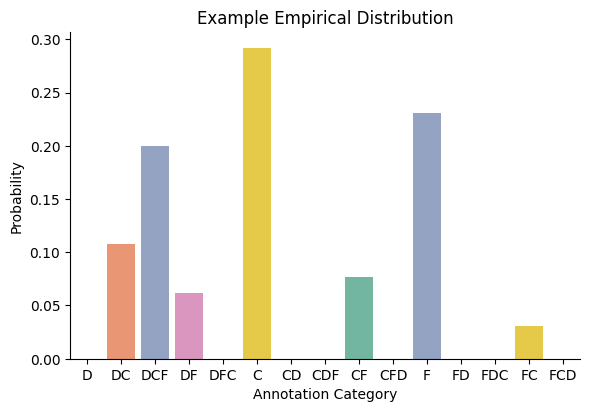

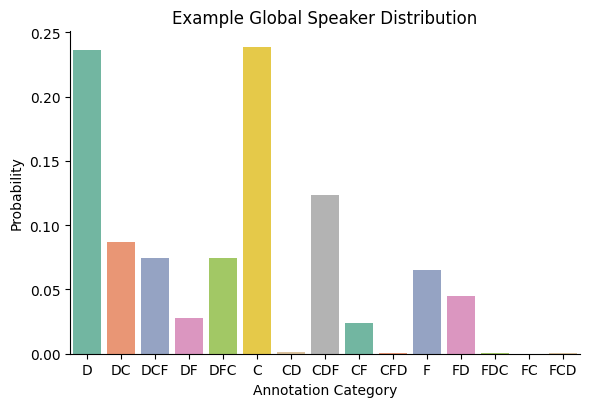

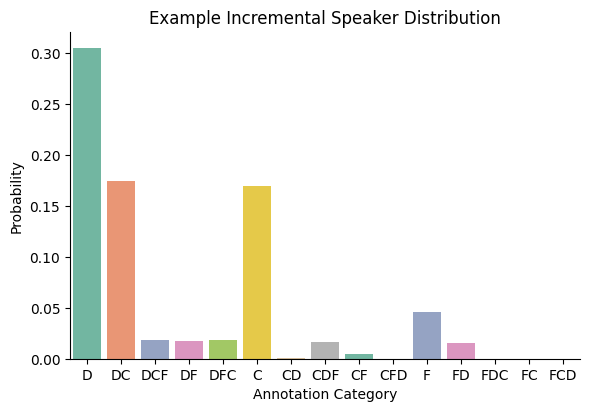

In [8]:
# Print examples
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print("Example state:", example_state)
print("Example annotation_flat:", example_annotation_flat)
print("Example annotation:", example_annotation)
print("Example empirical distribution:", example_empirical_dist)
# plot the example empirical distribution as catplot 
# ========================

def plot_utterance_distribution(distribution_array, titel = "Example Empirical Distribution"):
    df_plot_example_empirical_dist = pd.DataFrame({
        "annotation": list(flat2categories.values()),
        "probability": distribution_array
    })
    sns.catplot(
        data=df_plot_example_empirical_dist,
        kind="bar",
        x="annotation",
        y="probability",
        height=4,
        aspect=1.5,
        sharey=True,
        hue="annotation",
        palette="Set2"
    )
    plt.title(titel)
    plt.xlabel("Annotation Category")
    plt.ylabel("Probability")
    plt.show()


example_listener_matrix = incremental_semantics_jax(example_state, 0.95, 0.95, 0.5, 0.5)
print("Example listener matrix shape:", example_listener_matrix.shape)
print("Example listener matrix:", example_listener_matrix)
plot_utterance_distribution(example_empirical_dist, titel="Example Empirical Distribution")
k = 0.1
color_semval = 0.5
example_global_speaker = global_speaker(example_state, alpha=1,
                                         k=k, color_semval= color_semval, bias_subjectivity=-5, bias_length=1.5)[0,]
plot_utterance_distribution(example_global_speaker, titel="Example Global Speaker Distribution")
example_incremental_speaker = incremental_speaker(example_state, alpha=1, k=k, color_semval=color_semval, bias_subjectivity=1, bias_length=1.5)
plot_utterance_distribution(example_incremental_speaker, titel="Example Incremental Speaker Distribution")

### Module 3: Bayesian Inference

We implement the likelihood function in three different ways, depending on how the model handles categorical responses:

- **1. Hard labels with categorical likelihood**  
  The model observes one-hot labels and outputs a probability vector over categories.  
  A standard categorical likelihood is used:
  $$
  y_i \sim \text{Categorical}(\text{probs})
  $$

- **2. Hard labels with a Dirichlet prior on category probabilities**  
  To mitigate overfitting and handle data sparsity, we place a Dirichlet prior on the categorical probabilities.  
  The model outputs the **concentration parameters** of a Dirichlet distribution, and the categorical likelihood is derived from the Dirichlet posterior.

- **3. Soft labels with negative cross-entropy loss**  
  Instead of using hard labels, we use **empirical soft distributions** over categories.  
  The log-likelihood is computed via the expected log-probability (i.e., negative cross-entropy), implemented as:
  ```python
  numpyro.factor("loglik", jnp.sum(empirical * jnp.log(utt_probs + eps), axis=-1))

In [9]:
# Define likelihood function
def likelihood_function(states = None, empirical = None, speaker = "global", flag_predictive: bool = False, flag_soft_distribution: bool = False):
    # Initialize the parameter priors
    alpha = numpyro.sample("alpha", dist.HalfNormal(2))
    color_semval = numpyro.sample("color_semvalue", dist.Uniform(0, 1))
    k = numpyro.sample("k", dist.Uniform(0, 1))
    bias_subjectivity = numpyro.sample("bias_subjectivity", dist.Normal(0.0, 2.0))
    #bias_length = 0.5
    bias_length = numpyro.sample("bias_length", dist.Uniform(0, 1))
    eps = 1e-20  # Small value to avoid numerical issues
    
    # Define the likelihood function
    with numpyro.plate("data", len(states)):
        if speaker == "global":
            # Get vectorized global speaker output for all states
            results_vectorized_global_speaker = vectorized_global_speaker(states, alpha, color_semval, k, bias_subjectivity, bias_length) #shape (nbatch_size, n_utt, n_obj)
            # Build a new probs vector of shape (n_states, n_utt), where the matix is reduced to the first row (referent index 0) along the second axis (n_obj)
            utt_probs_conditionedReferent = results_vectorized_global_speaker[:,0,:] # Get the probs of utterances given the first state, referent is always the first state
        elif speaker == "incremental":
            # Get vectorized incremental speaker output for all states
            utt_probs_conditionedReferent = vectorized_incremental_speaker(states, alpha, color_semval, k, bias_subjectivity, bias_length)

        #numpyro.deterministic("utt_probs_conditionedReferent", utt_probs_conditionedReferent) # Store the probs for later use

        if flag_predictive:
            numpyro.sample("obs", dist.Categorical(probs=utt_probs_conditionedReferent))
        else:
            if not flag_soft_distribution:
                probs = utt_probs_conditionedReferent + eps
                numpyro.sample("obs", dist.Categorical(probs=probs), obs=empirical)
            else:
                empirical = jnp.log(empirical + eps)  # Convert empirical to log space
                numpyro.factor("loglik", jnp.sum(empirical * jnp.log(utt_probs_conditionedReferent + eps), axis=-1))

In [10]:
def run_mcmc(
    states: jnp.ndarray,
    empirical: jnp.ndarray,
    num_warmup: int = 1000,
    num_samples: int = 1000,
    num_chains: int = 4,
    speaker: str = "global",
    flag_predictive: bool = False,
    flag_soft_distribution: bool = False
):
    """
    Run MCMC to sample from the posterior distribution.
    
    Args:
        states: jnp.ndarray of shape (n_states, 6, 3)
        empirical: jnp.ndarray of shape (n_states,)
        num_warmup: number of warmup iterations
        num_samples: number of samples to draw
        num_chains: number of chains to run
        speaker: "global" or "incremental"
        flag_predictive: whether to use Predictive inference
        flag_soft_distribution: whether to use soft distribution
    Returns:
        MCMC object with samples and diagnostics.
    """
    if flag_soft_distribution:
        data = import_dataset(
            flag_output_empirical_dist_by_conditions=True
        )
        empirical = data["empirical_dist_by_condition"]  # shape (n_conditions, n_utterances)
        states= data["states_array_by_condition"]  # shape (n_conditions
    else: 
        data = import_dataset()
        empirical = data["empirical_seq_flat"]  # shape (n_states,)
        states = data["states_train"]  # shape (n_states, 6, 3)
    # Set the random key
    rng_key = random.PRNGKey(42)
    # MCMC kernel
    kernel = numpyro.infer.NUTS(likelihood_function, target_accept_prob=0.9, max_tree_depth=10)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
    )
    mcmc.run(rng_key, states=states, empirical=empirical, speaker=speaker, flag_predictive=flag_predictive, flag_soft_distribution=flag_soft_distribution)
    
    return mcmc

# Define file name
speaker = "global"  # or "incremental"
flag_soft_distribution = False  # Set to True for soft distribution, False for hard distribution
datatype = "soft" if flag_soft_distribution else "hard"

file_name = f"mcmc_{speaker}_{datatype}"


# Run MCMC for global speaker
mcmc_object = run_mcmc(states_train, empirical_train, num_warmup=100, num_samples=250, num_chains=4, speaker=speaker, flag_predictive=False, flag_soft_distribution=flag_soft_distribution)
print("Global Speaker MCMC diagnostics:")
print(mcmc_object.print_summary())
posterior_samples = mcmc_object.get_samples()

Compiling.. :   0%|          | 0/350 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/350 [00:03<?, ?it/s]




Running chain 0:   5%|▍         | 17/350 [00:11<02:37,  2.12it/s]


Running chain 0:  10%|▉         | 34/350 [11:33<2:05:19, 23.80s/it]


Running chain 0:  15%|█▍        | 51/350 [23:43<2:42:07, 32.53s/it]


Running chain 0:  19%|█▉        | 68/350 [35:41<2:50:53, 36.36s/it]


Running chain 0:  24%|██▍       | 85/350 [47:27<2:48:50, 38.23s/it]


Running chain 0:  29%|██▉       | 102/350 [59:10<2:42:21, 39.28s/it]


Running chain 0:  34%|███▍      | 119/350 [1:11:11<2:35:10, 40.30s/it]


Running chain 0:  39%|███▉      | 136/350 [1:23:18<2:26:33, 41.09s/it]




: 

: 

In [ ]:
df_posterior_samples = pd.DataFrame({k: v.tolist() for k, v in posterior_samples.items()})
file_name = f"posteriorSamples_{speaker}_{datatype}_production.csv"
df_posterior_samples.to_csv(file_name, index=False)
print(f"Posterior samples saved to {file_name}")

# read posterior samples from csv and store them in a dictionary



NameError: name 'posterior_samples' is not defined

In [26]:
import csv
def read_csv_to_dict(filename):
    data_dict = {}
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)
        for row in reader:
            for key, value in zip(header, row):
                if key in data_dict:
                    data_dict[key].append(float(value))
                else:
                    data_dict[key] = [float(value)]

    # Convert values to JAX arrays
    for key, values in data_dict.items():
        data_dict[key] = jnp.array(values)

    return data_dict
file_name = "posteriorSamples_incremental_soft_production.csv"
posterior_samples = read_csv_to_dict(file_name)

ValueError: could not convert string to float: '[[0.18383000791072845, 0.1571728140115738, 0.04768791049718857, 0.04803990572690964, 0.04768789932131767, 0.1609598696231842, 0.059707604348659515, 0.04877597466111183, 0.04037673398852348, 0.03037484921514988, 0.07776907831430435, 0.04987403005361557, 0.03037484921514988, 0.014590430073440075, 0.03037484921514988], [0.15147240459918976, 0.12233288586139679, 0.05794842168688774, 0.056146252900362015, 0.05794842168688774, 0.16007661819458008, 0.0464724563062191, 0.05927063152194023, 0.050546109676361084, 0.037919770926237106, 0.08888591825962067, 0.05968238040804863, 0.03791975602507591, 0.018265211954712868, 0.037919770926237106], [0.17291158437728882, 0.14543691277503967, 0.04498564079403877, 0.045333608984947205, 0.04498562961816788, 0.18015795946121216, 0.05524933338165283, 0.046012070029973984, 0.04805118963122368, 0.029628001153469086, 0.08697272837162018, 0.048462409526109695, 0.029628001153469086, 0.017363648861646652, 0.029628001153469086], [0.15533141791820526, 0.12563511729240417, 0.06377972662448883, 0.06155100092291832, 0.06377972662448883, 0.14208631217479706, 0.04772691801190376, 0.06523498892784119, 0.04217367246747017, 0.04121199995279312, 0.07909253984689713, 0.06470687687397003, 0.04121200740337372, 0.015239769592881203, 0.04121200740337372], [0.15458166599273682, 0.12265489995479584, 0.05831785500049591, 0.05767541378736496, 0.05831785500049591, 0.1264447718858719, 0.0465947762131691, 0.05964847281575203, 0.047038834542036057, 0.05136878043413162, 0.0863080695271492, 0.07954434305429459, 0.05136878043413162, 0.01699783280491829, 0.05136878043413162], [0.17285563051700592, 0.14519912004470825, 0.05306445062160492, 0.05249437317252159, 0.05306445062160492, 0.1588170975446701, 0.05515900254249573, 0.05427521839737892, 0.03998922184109688, 0.034288190305233, 0.0767337828874588, 0.05518590658903122, 0.034288190305233, 0.01445040199905634, 0.034288190305233], [0.11322428286075592, 0.0801563486456871, 0.08647283911705017, 0.07997544854879379, 0.08647283166646957, 0.09625712782144547, 0.03045019879937172, 0.08844586461782455, 0.056559968739748, 0.05587540194392204, 0.0961378738284111, 0.08407602459192276, 0.05587540194392204, 0.020438361912965775, 0.05587540194392204], [0.1132039725780487, 0.07997475564479828, 0.08626984804868698, 0.07998481392860413, 0.08626983314752579, 0.09653506428003311, 0.030381225049495697, 0.08823826164007187, 0.05681857466697693, 0.0557442307472229, 0.09657511860132217, 0.0840858593583107, 0.0557442307472229, 0.02053181082010269, 0.0557442307472229], [0.12249834090471268, 0.09055172652006149, 0.07951562851667404, 0.07392726838588715, 0.07951562851667404, 0.12739109992980957, 0.03439925238490105, 0.08132994920015335, 0.04913630709052086, 0.05137992650270462, 0.08673839271068573, 0.07771770656108856, 0.05137992650270462, 0.017755761742591858, 0.05137992650270462], [0.1462937295436859, 0.11669626086950302, 0.06192917749285698, 0.05947616696357727, 0.06192917749285698, 0.14155861735343933, 0.04433117434382439, 0.06334220618009567, 0.05711689218878746, 0.03950429707765579, 0.09646467119455338, 0.06182520464062691, 0.03950429707765579, 0.020639605820178986, 0.03950429707765579], [0.11301058530807495, 0.07997353374958038, 0.08626852184534073, 0.07979381829500198, 0.08626850694417953, 0.09677498042583466, 0.030380763113498688, 0.08823688328266144, 0.05702875927090645, 0.055743373930454254, 0.09665509313344955, 0.08388505131006241, 0.055743373930454254, 0.020607763901352882, 0.055743373930454254], [0.10693797469139099, 0.07466526329517365, 0.08022842556238174, 0.07444926351308823, 0.08022841066122055, 0.11141952872276306, 0.02836422808468342, 0.08205897361040115, 0.07073033601045609, 0.05184050276875496, 0.1111893504858017, 0.07826647162437439, 0.05184050276875496, 0.02555893547832966, 0.05184050276875496], [0.16464760899543762, 0.13609501719474792, 0.05953536927700043, 0.057953715324401855, 0.05953534319996834, 0.14180083572864532, 0.051700469106435776, 0.060893770307302475, 0.04178941249847412, 0.038561105728149414, 0.07880314439535141, 0.06105300784111023, 0.03856108710169792, 0.015100915916264057, 0.03856108710169792], [0.17041942477226257, 0.14230982959270477, 0.054523319005966187, 0.05389030650258064, 0.054523319005966187, 0.1478666216135025, 0.0540613979101181, 0.05576736852526665, 0.0443107932806015, 0.0352308563888073, 0.08231015503406525, 0.05665341392159462, 0.0352308563888073, 0.016012035310268402, 0.0352308563888073], [0.13563840091228485, 0.1021844893693924, 0.07689547538757324, 0.07299524545669556, 0.07689549028873444, 0.11094953864812851, 0.0388183631002903, 0.07864999026060104, 0.03928062692284584, 0.05725748836994171, 0.07573141157627106, 0.08690273761749268, 0.05725748836994171, 0.014194346964359283, 0.05725748836994171], [0.13515174388885498, 0.10358798503875732, 0.07436510175466537, 0.07012218236923218, 0.07436510175466537, 0.12553828954696655, 0.039351534098386765, 0.07606189697980881, 0.047878384590148926, 0.048051852732896805, 0.08568932861089706, 0.07371752709150314, 0.048051852732896805, 0.017301205545663834, 0.048051852732896805], [0.11260837316513062, 0.0794527679681778, 0.08568505942821503, 0.07947803288698196, 0.08568505942821503, 0.09799595177173615, 0.030182933434844017, 0.08764015138149261, 0.05814608931541443, 0.05536637455224991, 0.09803660959005356, 0.08355308324098587, 0.05536637455224991, 0.02101152390241623, 0.05536637455224991], [0.16493436694145203, 0.13703300058841705, 0.05600237473845482, 0.054772231727838516, 0.05600236356258392, 0.15204983949661255, 0.05205680429935455, 0.05728016421198845, 0.046504322439432144, 0.03473154082894325, 0.084498830139637, 0.05554472282528877, 0.03473154082894325, 0.016804678365588188, 0.03473154082894325], [0.15703293681144714, 0.12106990069150925, 0.048165615648031235, 0.04967840015888214, 0.048165615648031235, 0.13597235083580017, 0.0459926575422287, 0.049264609813690186, 0.03746972605586052, 0.06898441910743713, 0.07556407898664474, 0.10492430627346039, 0.06898441165685654, 0.013539960607886314, 0.06898441165685654], [0.1629631072282791, 0.13096430897712708, 0.05345293506979942, 0.053668975830078125, 0.05345293506979942, 0.13922518491744995, 0.049751389771699905, 0.054672565311193466, 0.03982144966721535, 0.05175073444843292, 0.07749989628791809, 0.08042232692241669, 0.05175073444843292, 0.01438977476209402, 0.05175073444843292], [0.15994009375572205, 0.13167352974414825, 0.052256930619478226, 0.05140538513660431, 0.052256930619478226, 0.16520622372627258, 0.05002081021666527, 0.05344926938414574, 0.05263260006904602, 0.03376640006899834, 0.09173424541950226, 0.05404108762741089, 0.03376640006899834, 0.019019177183508873, 0.03376640006899834], [0.1373329907655716, 0.1064048632979393, 0.07172704488039017, 0.06769654899835587, 0.07172702997922897, 0.12905366718769073, 0.040421631187200546, 0.07336362451314926, 0.04991032928228378, 0.046347226947546005, 0.08794321864843369, 0.07116752117872238, 0.046347226947546005, 0.018035463988780975, 0.046347226947546005], [0.18305499851703644, 0.15627838671207428, 0.047858402132987976, 0.04817885532975197, 0.04785838723182678, 0.16090357303619385, 0.0593678280711174, 0.048950377851724625, 0.04036838561296463, 0.030894219875335693, 0.07774188369512558, 0.05060684680938721, 0.030894210562109947, 0.014587410725653172, 0.030894219875335693], [0.1536431759595871, 0.12386250495910645, 0.06324458122253418, 0.06121569871902466, 0.06324458122253418, 0.13072803616523743, 0.04705353081226349, 0.06468761712312698, 0.05031653866171837, 0.04086620360612869, 0.08923172205686569, 0.06435438990592957, 0.04086620360612869, 0.018182257190346718, 0.04086620360612869], [0.14094462990760803, 0.10995099693536758, 0.07067065685987473, 0.06710560619831085, 0.07067065685987473, 0.12759459018707275, 0.04176875576376915, 0.07228316366672516, 0.048953570425510406, 0.045664649456739426, 0.08709291368722916, 0.07054629921913147, 0.045664649456739426, 0.01768973283469677, 0.045664649456739426], [0.1848115622997284, 0.1578252762556076, 0.04132053256034851, 0.04232719913125038, 0.04132053256034851, 0.1921931952238083, 0.05995549261569977, 0.042263343930244446, 0.03930835425853729, 0.026699727401137352, 0.07650841772556305, 0.04449743032455444, 0.026699727401137352, 0.014204362407326698, 0.026699727401137352], [0.1582958847284317, 0.12990115582942963, 0.05257106572389603, 0.051635172218084335, 0.05257106572389603, 0.16621503233909607, 0.04934752359986305, 0.053770579397678375, 0.053175006061792374, 0.03397025540471077, 0.09229440242052078, 0.05428386852145195, 0.03397025540471077, 0.019215179607272148, 0.03397025540471077], [0.1537085324525833, 0.12496747821569443, 0.05266984552145004, 0.051600899547338486, 0.05266984552145004, 0.1708972007036209, 0.047473303973674774, 0.05387160927057266, 0.05557740107178688, 0.03403322026133537, 0.09489427506923676, 0.05424662306904793, 0.03403322026133537, 0.02008330449461937, 0.03403322026133537], [0.14016622304916382, 0.11025043576955795, 0.061430852860212326, 0.05889592319726944, 0.061430852860212326, 0.1480848342180252, 0.04188249632716179, 0.06283251941204071, 0.061210811138153076, 0.03969425708055496, 0.1008283942937851, 0.06191568076610565, 0.03969424590468407, 0.022118978202342987, 0.03969424590468407], [0.15388648211956024, 0.12469147890806198, 0.06070763245224953, 0.058674417436122894, 0.06070763245224953, 0.13611748814582825, 0.04736844450235367, 0.062092795968055725, 0.05357906594872475, 0.03922692686319351, 0.09275684505701065, 0.061682816594839096, 0.03922692686319351, 0.019361181184649467, 0.03922692686319351], [0.11352910101413727, 0.08021797984838486, 0.08654109388589859, 0.08026599138975143, 0.08654109388589859, 0.09580735862255096, 0.03047361597418785, 0.08851569145917892, 0.05616138130426407, 0.055919501930475235, 0.09584710747003555, 0.08438145369291306, 0.055919501930475235, 0.02029433101415634, 0.055919501930475235], [0.1751437485218048, 0.14768047630786896, 0.05447619408369064, 0.05386295169591904, 0.05447619408369064, 0.15544673800468445, 0.05610163137316704, 0.055719174444675446, 0.038784436881542206, 0.03256883844733238, 0.07522972673177719, 0.05289483070373535, 0.03256883844733238, 0.01401504036039114, 0.03256883844733238], [0.16463235020637512, 0.1363111287355423, 0.05727455019950867, 0.05598114803433418, 0.05727454647421837, 0.14756934344768524, 0.05178256705403328, 0.058581385761499405, 0.04436175152659416, 0.03700859472155571, 0.08200887590646744, 0.0588514544069767, 0.03700858727097511, 0.016030453145503998, 0.03700859472155571], [0.14160798490047455, 0.10939634591341019, 0.06427652388811111, 0.062252335250377655, 0.06427652388811111, 0.12949992716312408, 0.041558053344488144, 0.06574311852455139, 0.04941902309656143, 0.05230298638343811, 0.088393434882164, 0.08010741323232651, 0.05230298638343811, 0.017857935279607773, 0.05230298638343811], [0.1715303212404251, 0.1439642757177353, 0.04527696967124939, 0.04555415362119675, 0.04527696594595909, 0.18105758726596832, 0.054689887911081314, 0.046310052275657654, 0.048469603061676025, 0.02972581423819065, 0.08740703016519547, 0.04856342077255249, 0.02972581423819065, 0.017514849081635475, 0.02972581423819065], [0.15412981808185577, 0.1254112273454666, 0.053332239389419556, 0.05218762531876564, 0.053332239389419556, 0.16884630918502808, 0.04764186218380928, 0.05454910546541214, 0.054589878767728806, 0.03446122631430626, 0.09375546872615814, 0.05486341193318367, 0.03446122631430626, 0.019726457074284554, 0.034461233764886856], [0.15678726136684418, 0.12788155674934387, 0.059651557356119156, 0.05783615633845329, 0.059651557356119156, 0.13558641076087952, 0.048580314964056015, 0.0610126368701458, 0.05316357687115669, 0.038452692329883575, 0.09239494055509567, 0.06067461147904396, 0.038452692329883575, 0.019211040809750557, 0.038452692329883575], [0.11073113977909088, 0.07799069583415985, 0.0840354859828949, 0.0778295025229454, 0.0840354859828949, 0.10230839252471924, 0.029627513140439987, 0.08595292270183563, 0.06210905313491821, 0.054300472140312195, 0.10218164324760437, 0.0818200558423996, 0.054300472140312195, 0.022443560883402824, 0.054300472140312195], [0.1595013588666916, 0.1312006413936615, 0.0523417703807354, 0.05146756395697594, 0.0523417703807354, 0.16547343134880066, 0.04984116554260254, 0.0535360611975193, 0.05277630686759949, 0.0338212288916111, 0.0918826088309288, 0.0541064590215683, 0.0338212288916111, 0.019071107730269432, 0.0338212288916111], [0.14972060918807983, 0.1197124645113945, 0.0647953674197197, 0.06222394481301308, 0.0647953674197197, 0.1460227519273758, 0.04547698423266411, 0.06627380102872849, 0.04409945756196976, 0.041868265718221664, 0.08128377050161362, 0.06541434675455093, 0.041868265718221664, 0.015935659408569336, 0.041868265718221664], [0.17166471481323242, 0.14435848593711853, 0.04749084636569023, 0.047472622245550156, 0.04749084636569023, 0.17653746902942657, 0.05483965203166008, 0.048574432730674744, 0.046800170093774796, 0.02975599840283394, 0.08522490411996841, 0.048576440662145615, 0.02975599840283394, 0.0169115848839283, 0.02975599840283394], [0.1415073126554489, 0.10669078677892685, 0.05815626308321953, 0.05800951272249222, 0.05815626308321953, 0.12556084990501404, 0.0405302532017231, 0.05948322266340256, 0.04602574184536934, 0.06515901535749435, 0.0857047289609909, 0.09870858490467072, 0.06515902280807495, 0.01663174480199814, 0.06515901535749435], [0.11226596683263779, 0.07934721559286118, 0.08556652069091797, 0.07915542274713516, 0.08556650578975677, 0.09855516999959946, 0.030142828822135925, 0.08751887083053589, 0.05864889919757843, 0.05528975650668144, 0.09843306988477707, 0.0832139402627945, 0.05528975650668144, 0.021193208172917366, 0.05528975650668144], [0.14312498271465302, 0.1124221459031105, 0.06492046266794205, 0.062347814440727234, 0.06492046266794205, 0.1339566856622696, 0.04270750656723976, 0.06640174984931946, 0.05232580006122589, 0.045645151287317276, 0.0912843644618988, 0.07057937234640121, 0.045645151287317276, 0.018908312544226646, 0.045645151287317276], [0.16477784514427185, 0.1363636553287506, 0.05829206854104996, 0.05685199424624443, 0.05829206854104996, 0.1448557823896408, 0.05180253088474274, 0.05962211638689041, 0.04320122301578522, 0.03766607493162155, 0.08050087839365005, 0.059766944497823715, 0.03766607493162155, 0.015611081384122372, 0.03766607493162155], [0.1281242072582245, 0.09701861441135406, 0.07185554504394531, 0.06750556826591492, 0.07185554504394531, 0.1379564255475998, 0.036855921149253845, 0.073495052754879, 0.05536733940243721, 0.04643026739358902, 0.0939321368932724, 0.07096677273511887, 0.04643026739358902, 0.02000739611685276, 0.04643026739358902], [0.14055626094341278, 0.11049048602581024, 0.06874586641788483, 0.06515190005302429, 0.06874586641788483, 0.13645975291728973, 0.04197368770837784, 0.07031441479921341, 0.054434165358543396, 0.040234073996543884, 0.09314404428005219, 0.06279847770929337, 0.040234073996543884, 0.019670186564326286, 0.040234073996543884], [0.14560100436210632, 0.1158769428730011, 0.0709788054227829, 0.06710103154182434, 0.0709788054227829, 0.1291714310646057, 0.04401993751525879, 0.07259830087423325, 0.05011073499917984, 0.03926713019609451, 0.08816922456026077, 0.06156221032142639, 0.03926713019609451, 0.018107879906892776, 0.03926713019609451], [0.1585114449262619, 0.128676638007164, 0.06509637832641602, 0.06280582398176193, 0.0650964081287384, 0.13514822721481323, 0.04888234660029411, 0.06658169627189636, 0.03907570615410805, 0.04206276684999466, 0.07523044943809509, 0.06602606922388077, 0.04206276684999466, 0.01412030030041933, 0.04206276684999466], [0.14013688266277313, 0.11018282920122147, 0.06215928494930267, 0.05952071398496628, 0.06215927004814148, 0.14658242464065552, 0.04185681790113449, 0.0635775551199913, 0.060293905436992645, 0.040164921432733536, 0.09980543702840805, 0.06257250159978867, 0.040164921432733536, 0.021787647157907486, 0.040164921432733536], [0.10737613588571548, 0.07506044954061508, 0.08068440854549408, 0.07484491169452667, 0.08068437874317169, 0.11036182194948196, 0.028514347970485687, 0.08252536505460739, 0.06971384584903717, 0.05213513225317001, 0.1101338267326355, 0.07868240028619766, 0.05213513225317001, 0.02519161067903042, 0.05213513225317001], [0.14919006824493408, 0.11975881457328796, 0.059698015451431274, 0.05767736956477165, 0.059698015451431274, 0.14247341454029083, 0.04549458622932434, 0.06106012687087059, 0.05749385803937912, 0.03906355798244476, 0.09708806872367859, 0.06131032854318619, 0.03906355798244476, 0.020775824785232544, 0.03906355798244476], [0.17571888864040375, 0.14835785329341888, 0.046497754752635956, 0.04672747850418091, 0.04649774730205536, 0.18150454759597778, 0.0563589408993721, 0.04755868762731552, 0.04146478697657585, 0.030045049265027046, 0.07875830680131912, 0.04912332445383072, 0.030045049265027046, 0.014983607456088066, 0.030045049265027046], [0.14921113848686218, 0.11975839734077454, 0.06093333661556244, 0.05872800946235657, 0.06093331053853035, 0.14029467105865479, 0.0454944409430027, 0.06232362240552902, 0.05622309446334839, 0.039372749626636505, 0.09560336172580719, 0.06173914670944214, 0.039372749626636505, 0.02031661942601204, 0.039372749626636505]]'

### Module 4: Posterior Analysis

In [23]:
# Run posterior predictive sampling
rng_key = random.PRNGKey(42)
get_posterior_predictive = Predictive(likelihood_function, posterior_samples=posterior_samples)
posterior_predictive = get_posterior_predictive(rng_key, states_train, flag_predictive=True)

TypeError: Dtype object is not a valid JAX array type. Only arrays of numeric types are supported by JAX.

In [ ]:
# Setup a DataFrame for the summary of the experiment, compute proportions of each annotation category by conditions, and compute bootstrap confidence intervals
df = import_dataset()["df"]
# Only keep the relevant columns for the experiment, conditions
df_experiment = df[["relevant_property", "sharpness", "item", "list", "statesArray", "annotation_seq_flat"]].copy()

# Relabel the relevant_property column for clarity
df_experiment["relevant_property"] = df_experiment["relevant_property"].replace({
    "first": "size_relevant",
    "second": "color_relevant",
    "both": "both_relevant"
})

# Collapse two factors into one conditions column, combine with _
df_experiment["conditions"] = df_experiment["relevant_property"] + "_" + df_experiment["sharpness"]
# Drop unnecessary columns, now it only contains the conditions, and annotation_seq_flat
df_experiment = df_experiment.drop(columns=["relevant_property", "sharpness", "item", "list", "statesArray"])  # Drop the original columns

# Setup a dataframe for the model for later use
df_model = df_experiment.copy()
df_model = df_model.drop(columns=["annotation_seq_flat"])  # Drop the annotation_seq_flat column for the model

# Function to compute bootstrap CI and standard error
def bootstrap_proportion_ci(series, category, n_boot=1000, ci=0.95):
    props = []
    for _ in range(n_boot):
        sample = series.sample(frac=1, replace=True)
        prop = (sample == category).mean()
        props.append(prop)
    mean = np.mean(props)
    lower = np.percentile(props, (1 - ci) / 2 * 100)
    upper = np.percentile(props, (1 + ci) / 2 * 100)
    se = np.std(props)
    return mean, se, lower, upper

results = []
for cond, group_df in df_experiment.groupby("conditions"):
    annots = group_df["annotation_seq_flat"]
    for cat in sorted(df["annotation_seq_flat"].unique()):
        count = (annots == cat).sum()
        proportion, se, lower, upper = bootstrap_proportion_ci(annots, cat)
        results.append({
            "condition": cond,
            "annotation": cat,
            "probs_exp": proportion,
            "se_exp": se,
        })

df_summary_exp = pd.DataFrame(results)

In [ ]:
# Generate posterior predictive samples
# Setup a DataFrame for the posterior predictive samples by mean proportions by conditions and se
posterior_predictive_samples = posterior_predictive['obs'] # shape n_samples, n_trials

n_samples, n_trials = posterior_predictive_samples.shape

# Convert to DataFrame
posterior_df = pd.DataFrame(
    posterior_predictive_samples,
    columns=[f"trial_{i}" for i in range(n_trials)]
)

# Melt to long format: one row per (sample, trial)
posterior_long = posterior_df.melt(var_name="trial", value_name="annotation", ignore_index=False)
posterior_long = posterior_long.reset_index().rename(columns={"index": "sample_id"})

# Recover original trial index
posterior_long["trial_index"] = posterior_long["trial"].str.extract(r"(\d+)").astype(int)

# df_model has: trial_index → conditions
df_model = df_model.reset_index(drop=True)
df_model["trial_index"] = df_model.index

# Merge
posterior_long = posterior_long.merge(df_model, on="trial_index", how="left")

# Count frequency of annotations per sample and condition
grouped = (
    posterior_long.groupby(["sample_id", "conditions", "annotation"])
    .size()
    .reset_index(name="count")
)

# Compute proportion within each sample-condition
grouped["proportion"] = grouped["count"] / grouped.groupby(["sample_id", "conditions"])["count"].transform("sum")

df_summary_model = (
    grouped.groupby(["conditions", "annotation"])["proportion"]
    .agg([
        ("mean_probs_model", "mean"),
        ("se_model", lambda x: x.std(ddof=1) / np.sqrt(len(x)))
    ])
    .reset_index()
)

# Combine empirical and model summaries by columns
df_summary = pd.concat([df_summary_exp, df_summary_model], axis=1)

file_name = f"summary_{speaker}_{datatype}_productionPredictive.csv"
# Save df_summary to CSV for further analysis
df_summary.to_csv(file_name, index=False)


A qualitative comparison of model predictions and empirical results. With panel plots side by side.

Posterior predictive samples shape: (1000, 3196)


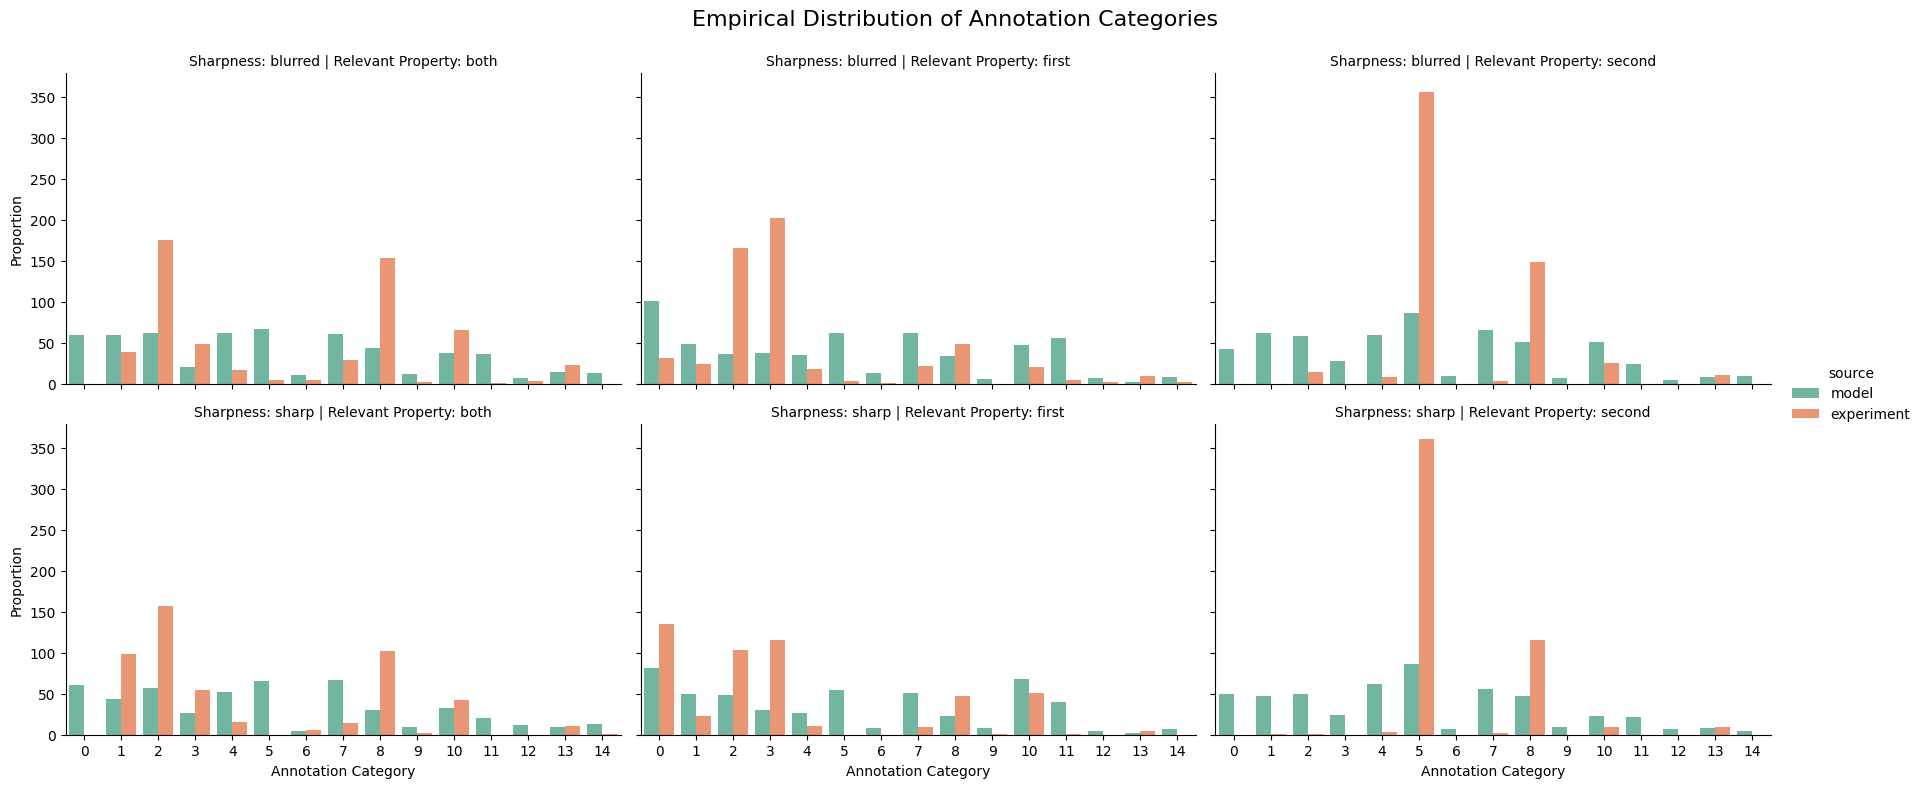

In [ ]:
posterior_predictive_samples = posterior_predictive['obs']
print("Posterior predictive samples shape:", posterior_predictive_samples.shape)
df = import_dataset()["df"]
# Only keep the relevant columns for the experiment, conditions
df_experiment = df[["relevant_property", "sharpness", "item", "list", "statesArray", "annotation_seq_flat"]].copy()
df_model = df[["relevant_property", "sharpness", "item", "list", "statesArray"]].copy()

# Set up the DataFrame for the experiment
df_experiment["source"] = "experiment"
df_experiment = df_experiment.rename(columns={"annotation_seq_flat": "annotation"})
# Set up the DataFrame for the model
df_model["source"] = "model"
df_model["annotation"] = posterior_predictive_samples[1,].tolist()  # Add the posterior predictive samples

# Combine the DataFrames
df_plot = pd.concat([df_experiment, df_model], ignore_index=True)

df_plot = df_plot.groupby(['sharpness', 'relevant_property', 'annotation', "source"]).size().reset_index(name='count')
df_plot['proportion'] = df_plot['count'] / df_plot.groupby(['sharpness', 'relevant_property', "source"])['count'].transform('sum')

# Set up the plot
g = sns.catplot(
    data=df_plot,
    kind="bar",
    x="annotation",
    y="count",
    col="relevant_property",
    row="sharpness",
    height=4,
    aspect=1.5,
    sharey=True,
    hue="source",
    palette="Set2",
)

g.set_axis_labels("Annotation Category", "Proportion")
g.set_titles(row_template="Sharpness: {row_name}", col_template="Relevant Property: {col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Empirical Distribution of Annotation Categories", fontsize=16)

plt.show()

We have obtained initial posterior samples for the incremental speaker model, with likelihood with soft distributions.  
Both the effective sample sizes and $\hat{R}$ diagnostics indicate good convergence.

**Next steps:**
- Perform model comparison (e.g., using WAIC or LOO-CV)
- Conduct posterior predictive checks to evaluate model fit

![MCMC Summary](MCMC_summary_inc_production.png)